In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef, average_precision_score
from sklearn.metrics import classification_report, log_loss, accuracy_score, precision_score


import xgboost as xgb
from xgboost import plot_importance

In [2]:
ticker = "AAPL"
target_window = 5

df = pd.read_csv(
    f"csv/{ticker}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date format
) 

DatetimeIndex(['2018-03-19', '2018-03-20', '2018-03-21', '2018-03-22',
               '2018-03-23', '2018-03-26', '2018-03-27', '2018-03-28',
               '2018-03-29', '2018-04-02',
               ...
               '2025-11-14', '2025-11-17', '2025-11-18', '2025-11-19',
               '2025-11-20', '2025-11-21', '2025-11-24', '2025-11-25',
               '2025-11-26', '2025-11-28'],
              dtype='datetime64[ns]', name='Date', length=1934, freq=None)
  Conteggio etichette:
[1131  798]
  Totale righe: 1929
----------------------------------------


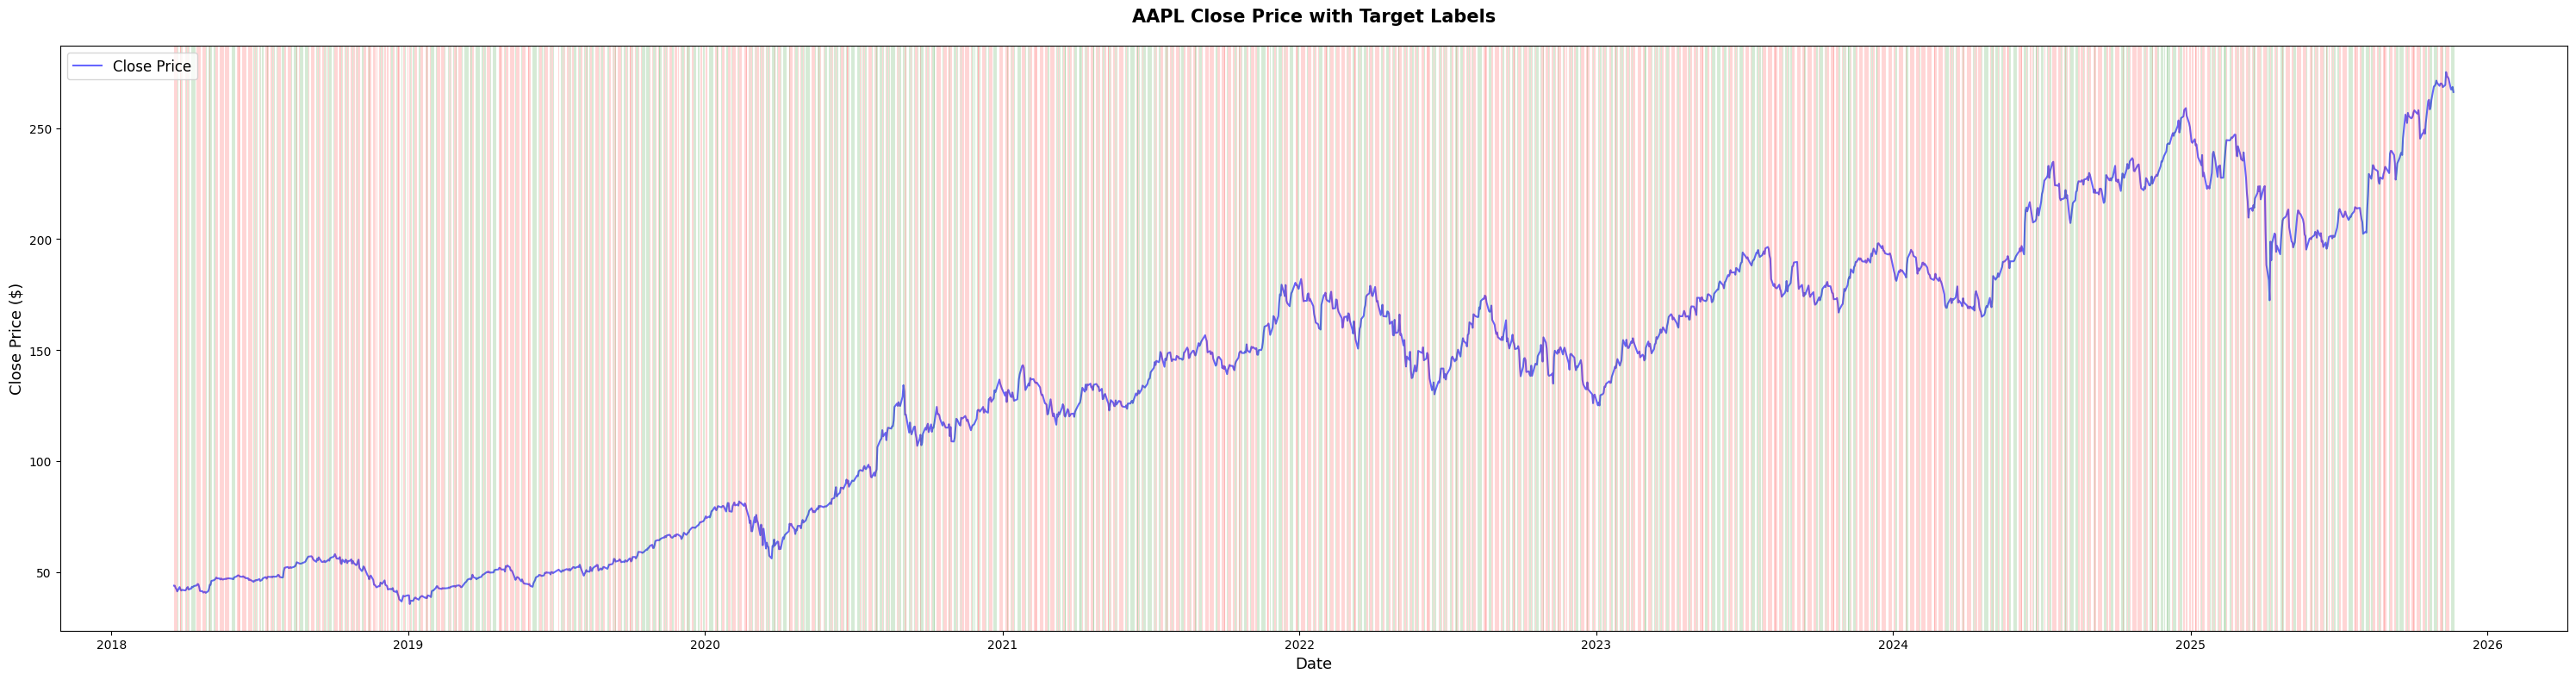

In [3]:
import importlib
import target
importlib.reload(target)
from target import calculate_target


df['Target'] = calculate_target(df, window=target_window, profit_take_pct=2, stop_loss_pct=1.0)

# Per vedere la fine del dataset, dato che come è construito il target perdiamo gli ultimi 5 giorni
print(df.index)
df = df.dropna(subset=["Target"])
df['Target'] = df['Target'].astype(int) # Converte in intero

tag_counts = df["Target"].value_counts()
print(f"  Conteggio etichette:")
print(tag_counts.values)
print(f"  Totale righe: {len(df)}")
print("-" * 40)


# Plot close prices
plt.figure(figsize=(30, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.6, linewidth=1.5)

# Plot vertical lines for each day
for idx in df.index:
    if df.loc[idx, 'Target'] == 1:
        plt.axvline(x=idx, color='green', alpha=0.15, linewidth=0.8, linestyle='-')
    else:
        plt.axvline(x=idx, color='red', alpha=0.15, linewidth=0.8, linestyle='-')



plt.xlabel('Date', fontsize=13)
plt.ylabel('Close Price ($)', fontsize=13)
plt.title(f'{ticker} Close Price with Target Labels', 
          fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()



In [4]:
#allFeatures = ['Close', 'High', 'Low', 'Open', 'Volume', 'Return', 'MACD', 'MACD_Signal', 'MACD_Hist', 'SMA', 'EMA20', 'Vol_EMA20', 'RSI', 'Boll_Up', 'Boll_Down', 'Dist_low_band', 'Dist_up_band', '%K', '%D', 'R_EMA20', 'ADX', '+DI', '-DI', 'ATR', 'BB_pctB', 'ROC', 'W%R', 'OBV', 'CMF', 'MACD_norm', 'RSI_diff', 'DI_diff', 'SMA_slope', 'RSI_slope', 'MACD_slope', '%K_slope', '%D_slope', 'ATR_slope', 'OBV_slope', 'ADX_slope', 'RSI_overbought', 'RSI_oversold', 'Stoch_overbought', 'Stoch_oversold', 'MACD_crossover_signal', 'Vol_pct_change', 'RSI_x_Vol_Change', 'ATR_pct', 'RSI_SMA15', 'RSI_vs_SMA', 'MACD_Hist_Std20', 'SP_Return', 'SP_RSI', 'SP_Dist_SMA']

#features = ["High","Volume","Return","MACD","MACD_Signal",
#            "MACD_Hist","EMA20","Vol_EMA20",
#            "RSI","Boll_Up","Boll_Down","Dist_low_band",
#            "Dist_up_band","%K","%D","R_EMA20","ADX","+DI",
#            "-DI","ATR","BB_pctB","ROC","OBV","CMF",
#            "MACD_norm","RSI_diff","DI_diff","SMA_slope",
#            "RSI_slope","MACD_slope","%K_slope","%D_slope",
#            "ATR_slope","OBV_slope","ADX_slope","RSI_overbought",
#            "RSI_oversold","Stoch_overbought","Stoch_oversold",
#            "MACD_crossover_signal","Vol_pct_change","RSI_x_Vol_Change",
#            "ATR_pct","RSI_SMA15","RSI_vs_SMA","MACD_Hist_Std20","SP_Return","SP_RSI","SP_Dist_SMA"]

features = ['Close', "High", 'Volume', 'Return', 'MACD', 'MACD_Hist', 'SMA', 'EMA20', 'Vol_EMA20', 'RSI', 'Boll_Up', 'Boll_Down', 'Dist_low_band', 'Dist_up_band', '%K', '%D', 'R_EMA20', 'ADX', 'ATR', 'ROC', 'OBV', 'CMF', 'MACD_norm', 'RSI_diff', 'DI_diff', 'SMA_slope', 'RSI_slope', 'MACD_slope', '%K_slope', 'ATR_slope', 'OBV_slope', 'ADX_slope', 'RSI_overbought', 'RSI_oversold', 'Stoch_overbought', 'Stoch_oversold', 'MACD_crossover_signal', 'Vol_pct_change', "RSI_x_Vol_Change", 'ATR_pct', 'RSI_SMA15', 'RSI_vs_SMA', 'MACD_Hist_Std20', 'SP_Return', 'SP_RSI', 'SP_Dist_SMA']

X = df[features]
y = df["Target"]


len(features)

46

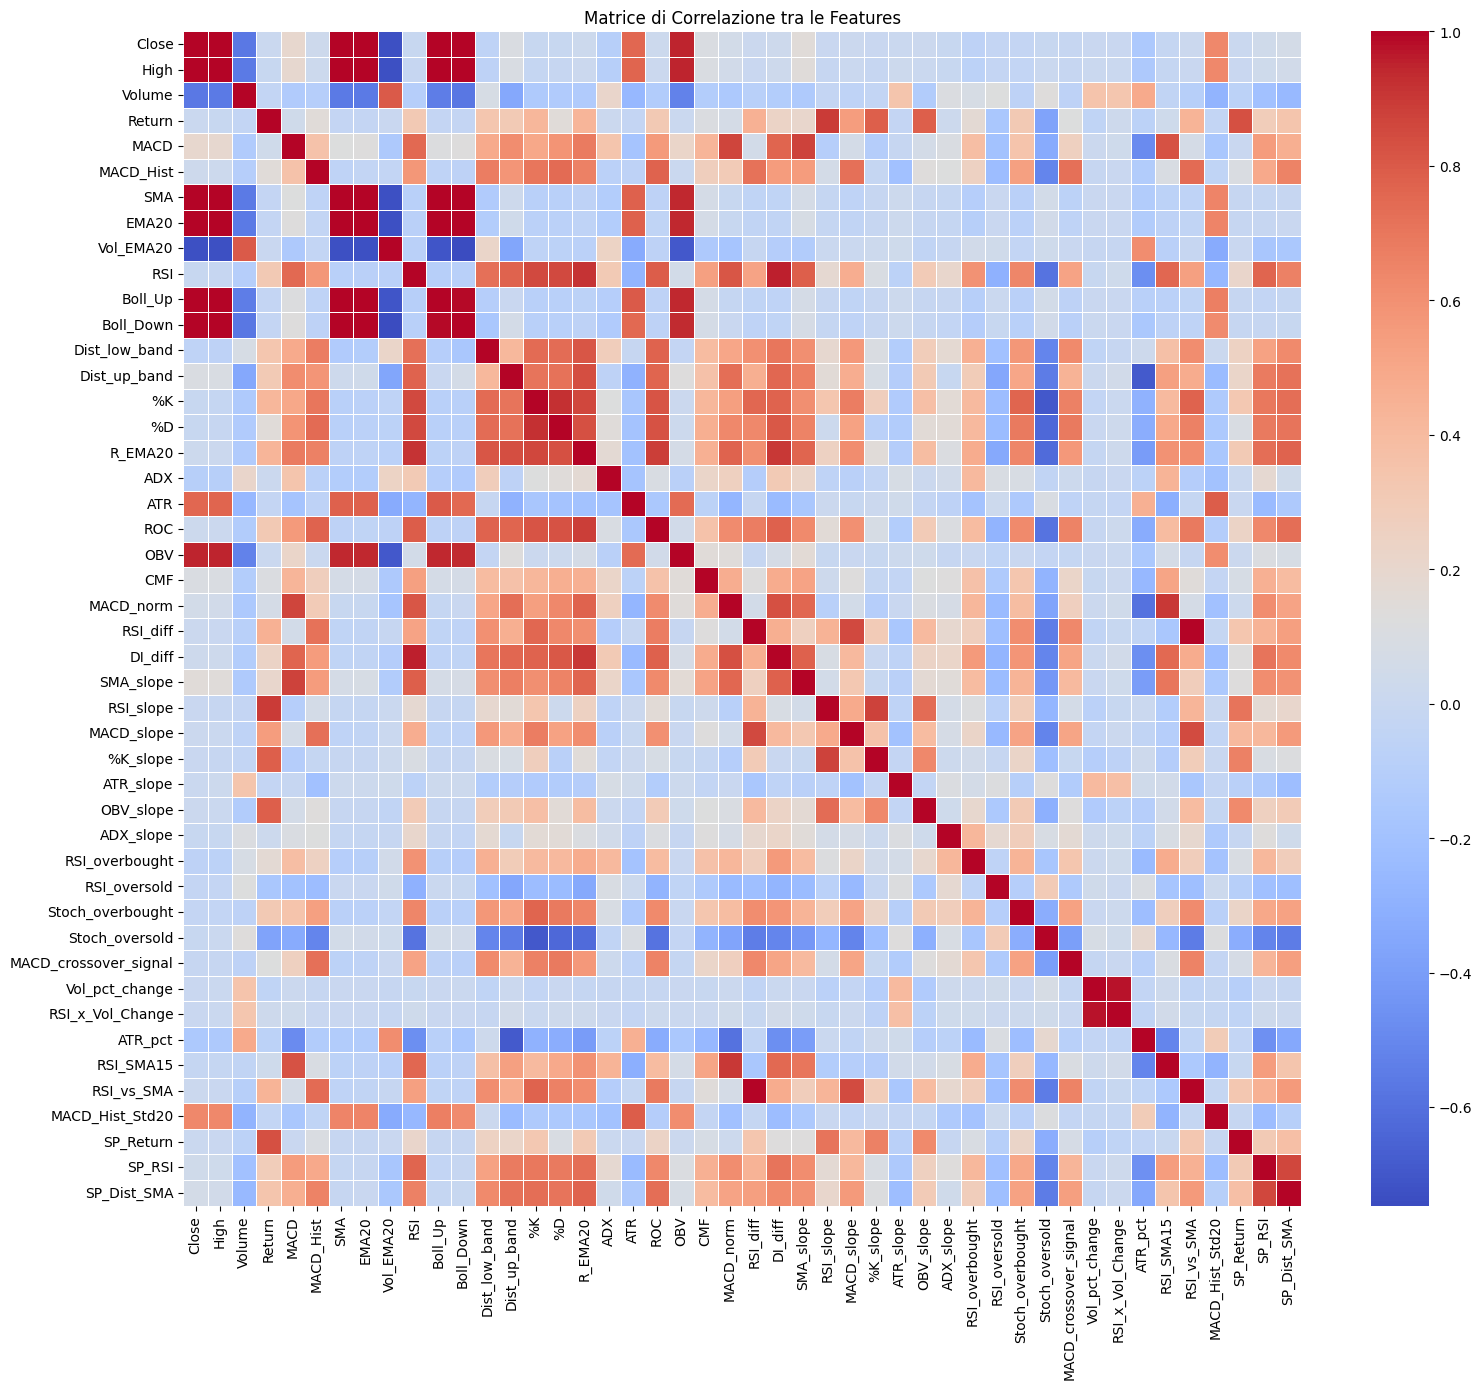


--- Coppie di Feature Altamente Correlate (> 0.9) ---
SMA                  <-> EMA20                :  0.9998
EMA20                <-> SMA                  :  0.9998
Close                <-> High                 :  0.9997
High                 <-> Close                :  0.9997
Boll_Up              <-> SMA                  :  0.9983
SMA                  <-> Boll_Up              :  0.9983
Boll_Up              <-> EMA20                :  0.9982
EMA20                <-> Boll_Up              :  0.9982
Boll_Down            <-> SMA                  :  0.9979
SMA                  <-> Boll_Down            :  0.9979
RSI_diff             <-> RSI_vs_SMA           :  0.9978
RSI_vs_SMA           <-> RSI_diff             :  0.9978
Boll_Down            <-> EMA20                :  0.9975
EMA20                <-> Boll_Down            :  0.9975
EMA20                <-> High                 :  0.9970
High                 <-> EMA20                :  0.9970
Close                <-> EMA20                :  

In [5]:
#Feature analisys parte 1:
#Correlation Matrix: Utile a discriminare quali feature forniscono le stesse informazioni al modello
#attraverso il rilevamento della loro dipendenza (LINEARE)

correlation_matrix = df[features].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matrice di Correlazione tra le Features")
plt.tight_layout()
plt.show()

corr_df = correlation_matrix.stack().reset_index()
corr_df.columns = ["Indice_A", "Indice_B", "Correlation"]

# Filtra per correlazioni alte (escludendo la correlazione di una feature con se stessa)
high_corr_pairs = corr_df[
    (corr_df["Correlation"].abs() > 0.9) & (corr_df["Indice_A"] != corr_df["Indice_B"])
]
print("\n--- Coppie di Feature Altamente Correlate (> 0.9) ---")
for idx, row in high_corr_pairs.sort_values(by="Correlation", ascending=False).iterrows():
    print(f"{row['Indice_A']:20s} <-> {row['Indice_B']:20s} : {row['Correlation']:7.4f}")


=== Mutual Information Score Ranking ===
                  Feature  MI_Score
10                Boll_Up  0.034047
20                    OBV  0.028014
41             RSI_vs_SMA  0.027394
18                    ATR  0.026379
9                     RSI  0.024059
16                R_EMA20  0.021392
1                    High  0.021209
39                ATR_pct  0.021091
11              Boll_Down  0.020639
6                     SMA  0.020230
13           Dist_up_band  0.019917
7                   EMA20  0.019623
12          Dist_low_band  0.015246
17                    ADX  0.014984
21                    CMF  0.013906
14                     %K  0.013269
30              OBV_slope  0.012925
2                  Volume  0.011881
40              RSI_SMA15  0.010362
31              ADX_slope  0.010139
0                   Close  0.009080
42        MACD_Hist_Std20  0.008239
26              RSI_slope  0.008163
28               %K_slope  0.007230
3                  Return  0.006412
45            SP_Dist_

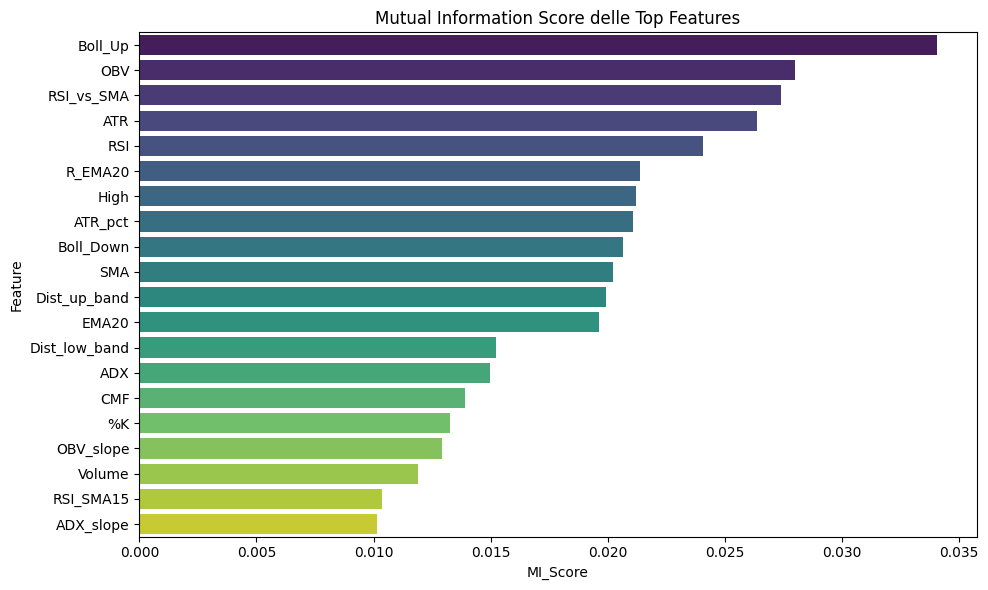

In [6]:
from sklearn.feature_selection import mutual_info_classif

# Mutual Information Score
# Misura la dipendenza tra due variabili. Un valore più alto significa maggiore dipendenza.
# Può catturare relazioni non lineari.

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    "Feature": features,
    "MI_Score": mi_scores
}).sort_values("MI_Score", ascending=False)

print("\n=== Mutual Information Score Ranking ===")
print(mi_df)


plt.figure(figsize=(10, 6))
sns.barplot(x="MI_Score", y="Feature", data=mi_df.head(20), hue="Feature", palette="viridis", legend=False)
plt.title("Mutual Information Score delle Top Features")
plt.tight_layout()
plt.show()

In [7]:

# --- DIVISIONE CRONOLOGICA IN TRE SET ---
# 70% Train, 15% Validation, 15% Test
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Dimensioni set: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")

#Conversione in DMatrix, formato di dati più efficiente per XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

print(X_test.index)


Dimensioni set: Train=1350, Validation=289, Test=290
DatetimeIndex(['2024-09-26', '2024-09-27', '2024-09-30', '2024-10-01',
               '2024-10-02', '2024-10-03', '2024-10-04', '2024-10-07',
               '2024-10-08', '2024-10-09',
               ...
               '2025-11-07', '2025-11-10', '2025-11-11', '2025-11-12',
               '2025-11-13', '2025-11-14', '2025-11-17', '2025-11-18',
               '2025-11-19', '2025-11-20'],
              dtype='datetime64[ns]', name='Date', length=290, freq=None)


In [8]:
num_rounds = 1000
early_stop = 20

/home/samu/MarGui-Project3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.339688041594454
Tuning degli ipermarametri con Optuna...


Best trial: 61. Best value: 0.606843: 100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


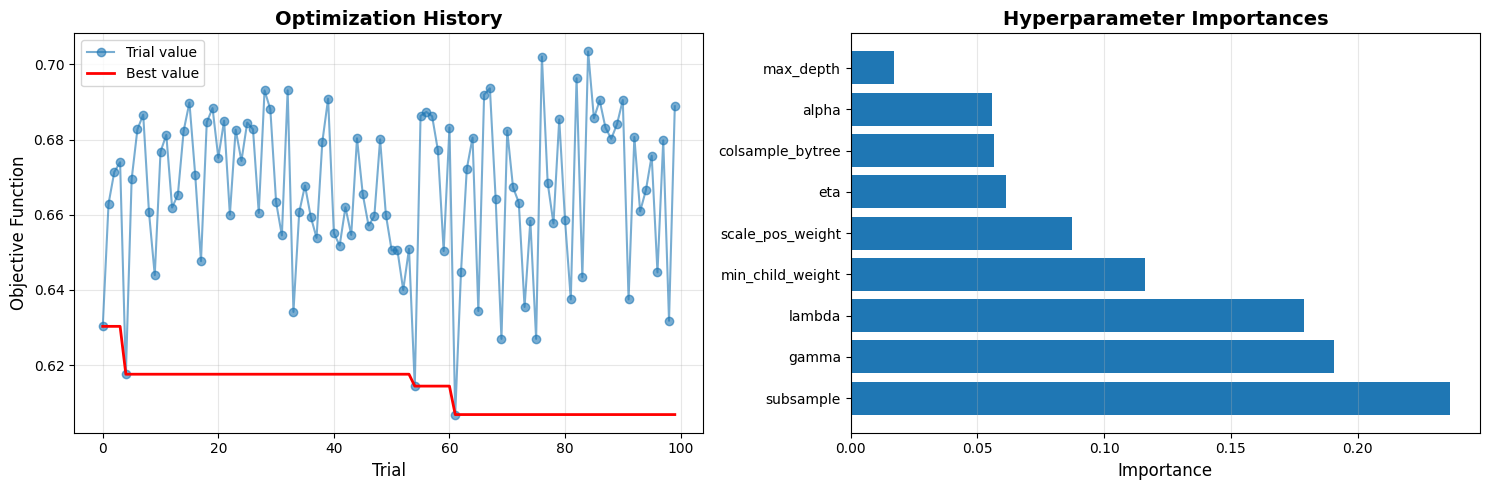

In [9]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# --- TUNING CON OPTUNA (TRAIN E VALIDATION) ---
pos_weight = np.sum(y_train == 0) / max(np.sum(y_train == 1), 1)
print(pos_weight)

def objective(trial: optuna.trial.Trial) -> float:
    params_trial = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'booster': 'gbtree', 
        'eta': trial.suggest_float('eta', 0.005, 0.05, log=True),
        
        'min_child_weight': trial.suggest_int('min_child_weight', 20, 35),
        
        'max_depth': trial.suggest_int('max_depth', 4, 6),
        'gamma': trial.suggest_float('gamma', 1.0, 10.0), 

        'lambda': trial.suggest_float('lambda', 1.0, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1.0, 10.0, log=True),
        
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.999 * pos_weight, 1.001 * pos_weight),
        
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'random_state': 42,
    }


    # NOTA: Ora usiamo dval (il validation set) per la valutazione nel tuning
    model = xgb.train(
        params=params_trial,
        dtrain=dtrain,
        num_boost_round=num_rounds,
        evals=[(dval, 'validation')],
        early_stopping_rounds=early_stop,
        verbose_eval=False
    )
    
    # Previsioni sul validation set
    preds_proba = model.predict(dval, iteration_range=(0, model.best_iteration))
    
    #AUC precision score
    score = average_precision_score(y_val, preds_proba) #nel return 1-score

    # Log Loss
    #score = log_loss(y_val, preds_proba)

    return float(1-score)

print("Tuning degli ipermarametri con Optuna...")
study = optuna.create_study(direction='minimize', study_name='xgboost_tuning')
study.optimize(objective, n_trials=100, show_progress_bar=True)

best_params = study.best_params


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Optimization history di Optuna
trials = study.trials
trial_numbers = [t.number for t in trials]
trial_values = [t.value for t in trials]

# Handle possible None values returned by incomplete/failed trials:
# - use +inf for min computation so None values don't interfere
# - use np.nan for plotting so matplotlib will skip them
numeric_for_min = [v if v is not None else float('inf') for v in trial_values]
plot_values = [v if v is not None else np.nan for v in trial_values]

best_values = [min(numeric_for_min[:i+1]) for i in range(len(numeric_for_min))]

ax1.plot(trial_numbers, plot_values, 'o-', alpha=0.6, label='Trial value')
ax1.plot(trial_numbers, best_values, 'r-', linewidth=2, label='Best value')
ax1.set_xlabel('Trial', fontsize=12)
ax1.set_ylabel('Objective Function', fontsize=12)
ax1.set_title('Optimization History', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot parameter importances
importances = optuna.importance.get_param_importances(study)
params_names = list(importances.keys())
params_values = list(importances.values())

ax2.barh(params_names, params_values)
ax2.set_xlabel('Importance', fontsize=12)
ax2.set_title('Hyperparameter Importances', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


Param = {
    'eta': 0.01916933173238384,
    'min_child_weight': 21,
    'max_depth': 4,
    'gamma': 9.16318859955668,
    'lambda': 7.076909019542535,
    'alpha': 4.336774520416064,
    'scale_pos_weight': 1.3402619136825444,
    'subsample': 0.8118140450202248,
    'colsample_bytree': 0.8505800393416793,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'random_state': 42,
}

CLASSIFICA FEATURE (Gain)
           Feature  Gain_Score
0              SMA   17.200491
1        Vol_EMA20   14.635970
2             High   13.457017
3          ATR_pct   12.938983
4     Dist_up_band   11.928206
5        MACD_norm   11.266088
6        RSI_SMA15   11.174510
7              OBV   10.365614
8          DI_diff   10.277580
9   Vol_pct_change   10.185531
10       OBV_slope    9.810284


/tmp/ipykernel_1821/2915697308.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gain_Score', y='Feature', data=imp_df.head(top_n_plot), palette='viridis')


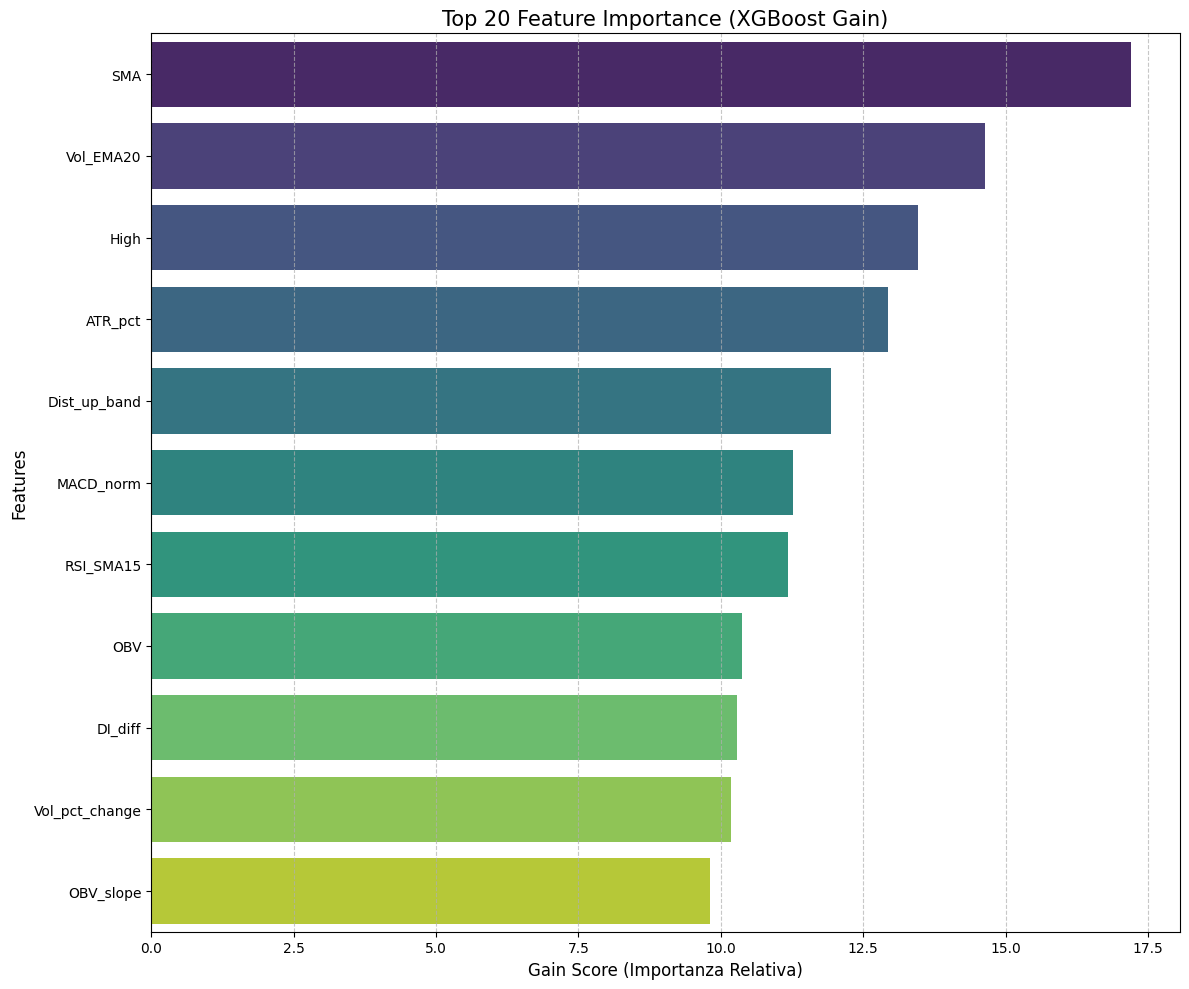

In [10]:
final_params = study.best_params
final_params['objective'] = 'binary:logistic'
final_params['eval_metric'] = 'logloss'
final_params['booster'] = 'gbtree'
final_params['random_state'] = 42

#final_params = fixed_params = {
#    'objective': 'binary:logistic',
#    'eval_metric': 'logloss',
#    'booster': 'gbtree',
#    'n_jobs': -1,
#    'random_state': 42,
#    'eta': 0.05,                 # Learning rate "medio"
#    'max_depth': 4,              # Profondità media
#    'subsample': 0.8,            # Standard
#    'colsample_bytree': 0.8,     # Standard
#    'min_child_weight': 10,      # Evita overfitting su pochi dati
#    'gamma': 1,                  # Leggera regolarizzazione
#    'scale_pos_weight': pos_weight # Spinta extra per trovare i Buy (opzionale)
#}



evals_result = {} 
print("Param = {")
for k, v in final_params.items():
    print(f"    '{k}': {repr(v)},")
print("}")

model = xgb.train(
    params=final_params,
    dtrain=dtrain,
    num_boost_round=num_rounds,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    evals_result=evals_result,
    early_stopping_rounds=early_stop,
    verbose_eval=False
)


#  Estrazione dei dati dal modello
# 'gain': Misura quanto l'uso di una feature migliora la precisione dell'albero.
#  (Alternative: 'weight', 'cover')
importance_dict = model.get_score(importance_type='gain')


imp_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Gain_Score'])
imp_df = imp_df.sort_values(by='Gain_Score', ascending=False).reset_index(drop=True)


print("\n" + "="*50)
print("CLASSIFICA FEATURE (Gain)")
print("="*50)
print(imp_df) 

plt.figure(figsize=(12, 10))

# Top feature da stampare
top_n_plot = 20
sns.barplot(x='Gain_Score', y='Feature', data=imp_df.head(top_n_plot), palette='viridis')

plt.title(f'Top {top_n_plot} Feature Importance (XGBoost Gain)', fontsize=15)
plt.xlabel('Gain Score (Importanza Relativa)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

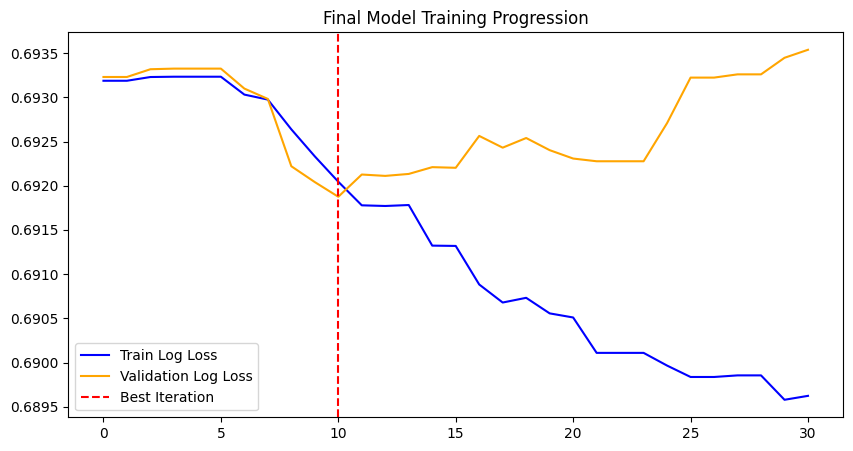

Ottimizzazione Completa.
Miglior K-Factor: 0.5
Miglior Validation MCC: 0.0640

Classification Report (Test Set):
              precision    recall  f1-score   support

           1       0.15      0.02      0.03       120
           0       0.57      0.94      0.71       170

    accuracy                           0.56       290
   macro avg       0.36      0.48      0.37       290
weighted avg       0.40      0.56      0.43       290

Matthews Corr Coef: -0.1143
Log Loss: 0.6928
Total Trades: 13 out of 290 days


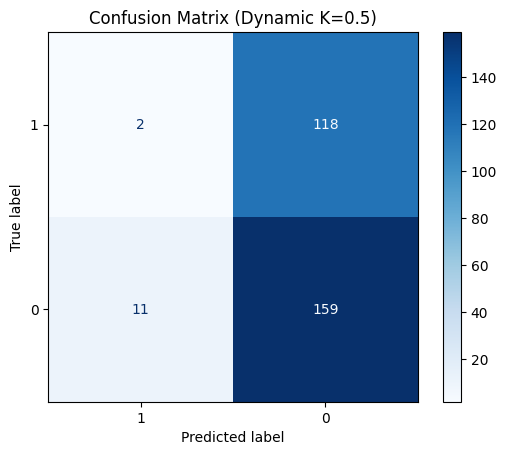

In [11]:
#Stampa della Loss
train_logloss = evals_result['train']['logloss']
val_logloss = evals_result['validation']['logloss']

plt.figure(figsize=(10, 5))
plt.plot(train_logloss, label='Train Log Loss', color='blue')
plt.plot(val_logloss, label='Validation Log Loss', color='orange')
plt.axvline(x=model.best_iteration, color='red', linestyle='--', label='Best Iteration')
plt.title('Final Model Training Progression')
plt.legend()
plt.show()


# Ricerca della soglia migliore (K)

#Probabilità minima per fare un trade
floor_probability = 0.40

val_probs = model.predict(dval, iteration_range=(0, model.best_iteration))
val_series = pd.Series(val_probs).astype(float)

# Intervallo di applicazione rolling z-score
window_size = 40  

# Valore di partenza MCC
best_mcc = -1

# Valore di partenza di k
best_k = 1.5 

# Ciclo di ricerca di K (Moltiplicatore per deviazione standard)
for k in np.arange(0.5, 2.0, 0.1):
    # Calcolo di media e std sulle probabilità
    roll_mean = val_series.rolling(window=window_size).mean()
    roll_std = val_series.rolling(window=window_size).std()
    
    dynamic_thresh = roll_mean + roll_std.mul(float(k))
    dynamic_thresh = dynamic_thresh.fillna(floor_probability)
    dynamic_thresh = np.maximum(dynamic_thresh,floor_probability) 

    # Genera predizioni
    # True -> 1, False -> 0.
    preds = (val_series > dynamic_thresh).astype(int)
    
    # Controlliamo di aver fatto dei trade, almeno tanti quanti i giorni
    # su cui calcoliamo il target
    if preds.sum() < target_window: continue 
    
    mcc = matthews_corrcoef(y_val, preds)
    if mcc > best_mcc:
        best_mcc = mcc
        best_k = k


print(f"Ottimizzazione Completa.")
print(f"Miglior K-Factor: {best_k:.1f}")
print(f"Miglior Validation MCC: {best_mcc:.4f}")



# PREDIZIONI E VALUTAZIONI SU TEST
test_probs = model.predict(dtest, iteration_range=(0, model.best_iteration))
test_series = pd.Series(test_probs).astype(float)

# --- WARM START TRICK ---
# Utilizzo gli ultimi 40 giorni di validation set per 
# per calcolare il K per l'inizio del test set

combined_series = pd.concat([val_series.iloc[-window_size:], test_series]).reset_index(drop=True)

roll_mean_test = combined_series.rolling(window=window_size).mean()
roll_std_test = combined_series.rolling(window=window_size).std()

# Utilizziamo il miglior k che abbiamo trovato prima
dynamic_thresh_test = roll_mean_test + roll_std_test.mul(float(best_k))
dynamic_thresh_test = np.maximum(dynamic_thresh_test, floor_probability)

# Rimuoviamo la parte di Validation che avevamo inserito inizialmente
dynamic_thresh_test = dynamic_thresh_test.iloc[window_size:].reset_index(drop=True)  # type: ignore

y_pred_test = (test_series > dynamic_thresh_test).astype(int)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test, labels=[1, 0]))

print(f"Matthews Corr Coef: {matthews_corrcoef(y_test, y_pred_test):.4f}")
print(f"Log Loss: {log_loss(y_test, test_probs):.4f}")
print(f"Total Trades: {y_pred_test.sum()} out of {len(y_pred_test)} days")


cm = confusion_matrix(y_test, y_pred_test, labels=[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Dynamic K={best_k:.1f})")
plt.show()

In [12]:
import os
import joblib

os.makedirs("models", exist_ok=True)

artifact = {
    "model": model,
    "features": X_train.columns.tolist() if hasattr(X_train, "columns") else None,
    "aggressive" : best_k,
    "param": final_params
}

out_path = f"models/{ticker}.joblib"
joblib.dump(artifact, out_path)


['models/AAPL.joblib']